# 신경망 알고리즘

신경망은 입력층, 중간층(은닉층), 출력층으로 구성되며, 각 층은 하나 이상의 노드로 구성된다. 그리고 서로 다른 층에 있는 노드들끼리만 연결된다. (동일레벨에서는 연결되지 않는다.) 신경망은 지도학습 알고리즘이므로 학습데이터로 설명변수와 그에 대한 정답인 목적변수를 포함한다.

활성화 함수로는 주로 ReLU(Rectified Linear Unit) 함수를 사용한다. (참고: https://pythonkim.tistory.com/40) ReLU 함수는 sigmoid 함수의 문제를 개선하여 나타난 함수이다. ReLU 함수를 코드로 구현하면 max(0,x)로, 음수에 대해서만 0으로 처리한다.

**sigmoid는 logistic classification에서 어디에 속하는지 분류를 하기 위해 사용했다. 일정 값을 넘어야 성공내지는 참(True)이 될 수 있기 때문에 Activation function이라고도 불렀다. 역전파를 할 때, sigmoid 함수가 값을 변형하는데, layer가 많은 경우 미분 결과를 최초 layer까지 올바르게 전달하지 못한다는 단점이 있다. ** 


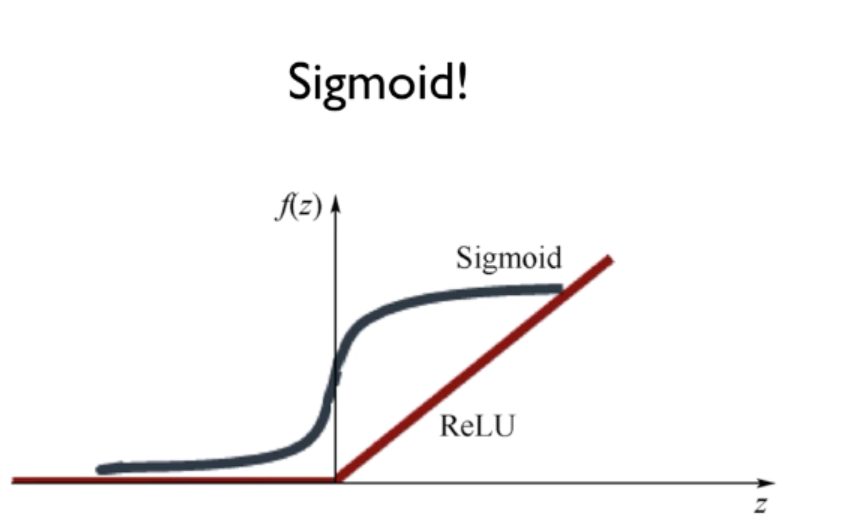

## 뉴럴 네트워크(Neural Networks)
뉴럴 네트워크는 torch.nn 패키지를 이용하여 생성할 수 있다. 즉, 모든 뉴럴 네트워크는 기본 클래스 nn.Module로부터 파생된 것이다. 뉴럴 네트워크의 상태는 레이어가 아니라 그래프에 저장된다.

**nn.Module : 여러 개의 layer와 output을 return하는 forward(input) 메소드를 포함한다.**

**모듈 : 일반적으로 본체에서 분리되어 작은 부분으로 유기적으로 구성되어 있다가 필요할 때 본체에 합류하여 그 기능을 수행할 수 있는 단위, 그 자체로 하나의 완전한 기능을 수행할 수 있는 독립된 실체를 의미한다. 프로그래밍에서 모듈은 기능(함수)별로 여럿을 하나로 모으거나 분할하는 것이다. 자바에서는 모듈 > 패키지 > 클래스의 포함관계이다.**


## 숫자 이미지를 분류하는 신경망을 예제로 살펴보기
참고 : PyTorch Tutorial 문서

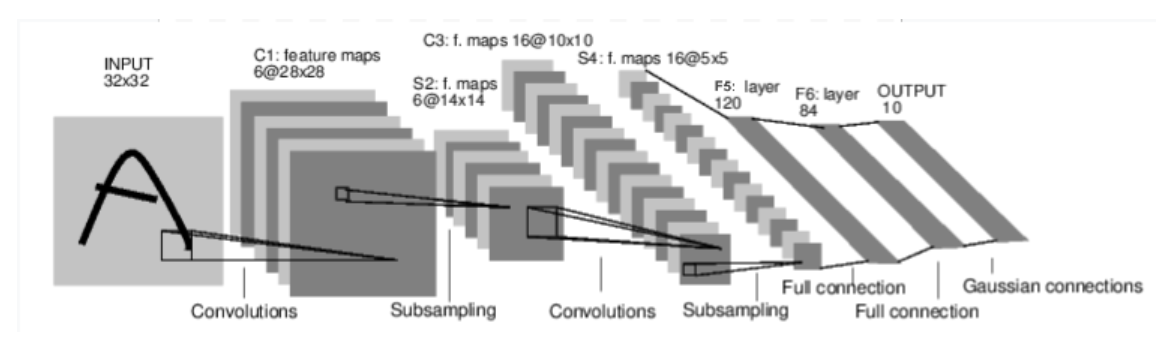

위 그림은 간단한 순전파 네트워크(Feed-forward network)로, 입력(input)을 받아 여러 계층에 차례로 전달한 후, 최종 출력(output)을 제공한다.

신경망(네트워크)의 일반적인 학습 과정은 다음과 같다:
<p>-학습 가능한 매개변수나 가중치(weight)가 있는 신경망을 정의한다.</p>
<p>-입력 데이터셋에 대한 반복 학습을 진행한다.</p>
<p>-신경망을 통해 입력값을 처리한다.</p>
<p>-손실(loss; 출력이 정답으로부터 얼마나 떨어져있는지 = 오차)을 계산한다.</p>
<p>-손실 계산 = 출력(output)과 정답(target)의 차이</p>
<p>-변화도(gradient)를 신경망의 매개변수들에 역전파 한다.</p>
<p>-아래의 방법으로 신경망의 가중치를 갱신한다.</p>
<p>가중치(wiehgt) = 가중치(weight) - 학습율(learning rate) * 변화도(gradient)</p>

### 신경망 정의하기

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


사용자는 직접 forward 함수만 정의하면 된다.그라디언트를 계산하는 backward 함수는 autograd를 사용함으로써 자동으로 정의된다. 사용자는 forward 함수에서 모든 텐서 연산을 사용할 수 있다.

모델의 학습가능한 매개변수들은 net.parameters()에 의해 return된다.

In [2]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


32x32 크기의 랜덤값을 신경망에 입력으로 넣어보면 다음과 같다.

Note: 이 신경망(LeNet)의 예상되는 입력 크기는 32x32이다. 이 신경망에 MNIST 데이터셋을 사용하기 위해서는, 데이터셋의 이미지 크기를 32x32로 변경해야 한다.

In [3]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0191,  0.0349,  0.0937, -0.0721, -0.0306, -0.0312,  0.0376,  0.0670,
          0.0722,  0.0378]], grad_fn=<AddmmBackward>)


모든 매개변수의 그라디언트 버퍼 값을 0으로 설정하고, 랜덤 값으로 역전파를 한다.

In [4]:
net.zero_grad()
out.backward(torch.randn(1, 10))

#### **Note**
<p>torch.nn 은 미니-배치(mini-batch)만 지원한다. 전체 torch.nn 패키지는 mini-bach 형태의 입력만을 지원하며, 단일 데이터(하나의 샘플)는 입력으로 지원하지 않는다.</p>

예를 들어, nnConv2D 는 nSamples x nChannels x Height x Width 의 4차원 Tensor를 입력으로 취한다.

만약 하나의 샘플만 있다면, input.unsqueeze(0)을 사용하여 가짜 배치 차원을 추가하면 된다.

지금까지 살펴봤던 것들을 다시 한번 정리하면 다음과 같다.

**torch.Tensor** - backward()와 같은 autograd 연산을 지원하는 다차원 배열로, tensor에 대한 변화도(gradient)를 갖고 있다.

**nn.Module** - 신경망 모듈. 매개변수를 캡슐화(encapsulation)하는 간편한 방법으로, GPU로 옮기거나, 내보내기(exporting), 불러오기(loading) 등의 작업을 위한 헬퍼(helper)를 제공한다.

**nn.Parameter** - tensor의 한 종류로, Module에 속성으로 할당될 때 매개변수로 자동 등록 된다.

**autograd.Function** - autograd 연산의 forward와 backward에 대한 정의를 구현한다. 모든 tensor 연산은 하나 이상의 function 노드를 생성하며, 각 노드는 tensor를 생성하고 기록(history)을 인코딩하는 여러 함수들에 연결된다.

**정리하면, 신경망을 정의하고, 입력처리 및 backward 호출에 대해 다루었다. **

### 손실함수 (Loss Function)

오차 함수는 (출력, 정답)을 한 쌍(pair)의 입력으로 받아, 출력(output)이 정답(target)으로부터 얼마나 멀리 떨어져있는지 추정하는 값을 계산한다.

nn 패키지에는 여러가지의 손실 함수들이 존재하는데, 가장 간단한 손실 함수로는 출력과 입력간의 평균제곱오차(mean-squared error)를 계산하는 nn.MSEloss 가 있다.

**nn.MSEloss 예시**

In [5]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.4639, grad_fn=<MseLossBackward>)


*dumpy target : 가짜로 만든 정답

다음으로, .grad_fn 속성을 이용하여 역방향으로 loss를 따라가면, 다음과 같은 연산 그래프를 볼 수 있다.

input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> view -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss
      
따라서 loss.backward()를 호출하면, 전체 그래프는 손실(loss)에 대하여 미분되며, 그래프 내의 requires_grad=True 인 모든 Tensor는 변화도(gradient)가 누적된 .grad Tensor를 갖게 된다.

예를 들어, 몇 단계를 역전파해보자.

In [6]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

#### 손실 역전파(Backprop)
오차(error)를 역전파하기 위해서는 loss.backward() 만 호출하면 된다. 다만 기존에 존재하는 그라디언트들을 초기화 할 필요가 있다. 그렇지 않으면 그라디언트가 기존의 것에 누적되어 저장되기 때문이다.

loss.backward()를 호출하여 역전파 전과 후에 conv1의 bias gradient를 살펴보자.

In [7]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0311,  0.0137,  0.0319,  0.0158,  0.0024,  0.0078])


### 가중치 갱신(Update the weights)
실제로 많이 사용되는 가장 단순한 갱신 규칙은 확률적 경사하강법(SGD; Stochastic Gradient Descent)이며 식은 다음과 같다.

**weight = weight - learning_rate*gradient**

간단하게 이를 구현해보자.

In [8]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

신경망을 구성할 때 SGD, Nesterov-SGD, Adam, RMSProp 등과 같은 다양한 갱신 규칙을 사용하고 싶을 수도 있다. 이를 위해 PyTorch는 위와 같은 갱신 규칙에 대한 방법들을 모두 구현해 놓은 torch.optim 패키지를 제공한다. 해당 패키지는 다음 코드와 같이 매우 간단하게 사용할 수 있다.

In [9]:
import torch.optim as optim

# Optimizer를 생성합니다.
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 학습 과정(training loop)에서는 다음과 같습니다:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

**Note**
역전파(Backprop) 섹션에서 앞서 설명한 것처럼 변화도가 누적되기 때문에 optimizer.zero_grad() 를 사용하여 수동으로 변화도 버퍼를 0으로 세팅한다.